# Vehicle Detection Project

## Collecting Data

In [128]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from scipy.misc import imread 

car_files = glob.glob('vehicles/vehicles/GTI_Far/image*.png')
car_files.extend(glob.glob('vehicles/vehicles/GTI_Left/image*.png')) 
car_files.extend(glob.glob('vehicles/vehicles/GTI_MiddleClose/image*.png')) 
car_files.extend(glob.glob('vehicles/vehicles/GTI_Right/image*.png')) 
car_files.extend(glob.glob('vehicles/vehicles/KITTI_extracted/*.png'))
#print (car_images)

non_car_files= glob.glob('non-vehicles/non-vehicles/GTI/*.png')
non_car_files.extend(glob.glob('non-vehicles/non-vehicles/Extras/*.png'))

print("number of car images=",len(car_files))
print("number of non car images=",len(non_car_files))

number of car images= 8792
number of non car images= 8968


## Sampling and Visualization of Data

Your function returned a count of 8792  cars and 8968  non-cars
1.0


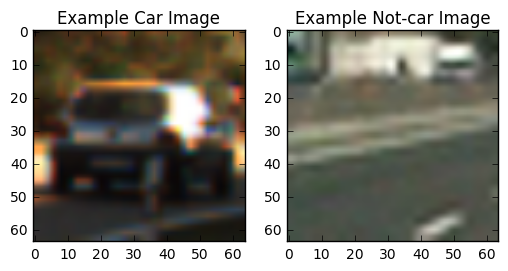

In [129]:
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    # Define a key "image_shape" and store the test image shape 3-tuple
    example_img=cv2.imread(car_list[0])
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    
    # Return data_dict
    return data_dict

data_info = data_look(car_files, non_car_files)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')

car_ind = np.random.randint(0, len(car_files))
notcar_ind = np.random.randint(0, len(non_car_files))
    
# Read in car / not-car images
car_image = imread(car_files[car_ind])
notcar_image = imread(non_car_files[notcar_ind])

print(np.max(car_image))
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.show()

## Definition Of Histogram based, Spatial Binning and HOG

In [130]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0],nbins,bins_range)
    ghist = np.histogram(img[:,:,1],nbins,bins_range)
    bhist = np.histogram(img[:,:,2],nbins,bins_range)
    # Generating bin centers
    bin_edges=rhist[1]
    bin_centers = (bin_edges[1:]+bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0],ghist[0],bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

def get_hog_features(img, orient=9, pix_per_cell= 8, cell_per_block= 2, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image= hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features= hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        return features
    
def feat_image(img,cspace):
    if cspace!='RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    else:
        feature_image=np.copy(img)
    return feature_image

def extract_features(imgs, cspace='RGB',method='ALL',hog_channel=0,spatial_size=(32,32),hist_bins=32,hist_range=(0, 256),orient=9, 
                        pix_per_cell=8, cell_per_block=2):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = imread(file)
        hist_features=None
        spatial_features=None
        comb_features=None
        # apply color conversion if other than 'RGB'
        feature_image=feat_image(image,cspace)  
        if (method=='hog')|(method=='hog+bin_spat')|(method=='hog+color_hist')|(method=='ALL'):
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            hog_features=np.array(hog_features)
            comb_features=hog_features
            
        if (method=='hog+color_hist')|(method=='color_hist+bin_spat')|(method=='ALL'):
            rhist, ghist, bhist, bin_centers,hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            hist_features=np.array(hist_features)
        if (method=='hog+bin_spat')|(method=='color_hist+bin_spat')|(method=='ALL'):
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            spatial_features=np.array(spatial_features)
        
        if (method!='hog')&(method!='hog+bin_spat')&(method!='hog+color_hist')&(method!='ALL')&(method!='color_hist+bin_spat'):
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            hog_features=np.array(hog_features)
            comb_features=hog_features
        if (method=='hog+color_hist'):
            comb_features=np.concatenate((comb_features,hist_features))
        if (method=='hog+bin_spat'):
            comb_features=np.concatenate((comb_features,spatial_features))
        if (method=='color_hist+bin_spat'):
            comb_features=np.concatenate((hist_features,spatial_features))
        if (method=='ALL'):
            comb_features=np.concatenate((comb_features,hist_features,spatial_features))
            
        features.append(comb_features)
        
    # Return list of feature vectors
    return features

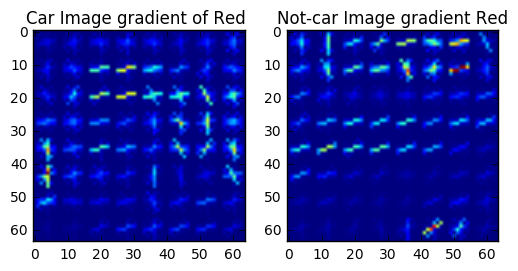

In [591]:
features,car_image_grad=get_hog_features(car_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
features,notcar_image_grad=get_hog_features(notcar_image[:,:,0], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image_grad)
plt.title('Car Image gradient of Red ')
plt.subplot(122)
plt.imshow(notcar_image_grad)
plt.title('Not-car Image gradient Red')
plt.show()

## Feature extraction 

In [237]:
#Parameters to tune in for
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.model_selection import train_test_split
orient = 9
pix_per_cell = 8
cell_per_block = 2
method='ALL'
spatial = 32
histbin = 32
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
color_space='YUV'
t=time.time()
car_features = extract_features(car_files,cspace=color_space,method=method,hog_channel=hog_channel, spatial_size=(spatial, spatial),hist_bins=histbin, hist_range=(0, 256),orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block)
non_car_features = extract_features(non_car_files, cspace=color_space,method=method,hog_channel=hog_channel, spatial_size=(spatial, spatial),hist_bins=histbin, hist_range=(0, 256),orient=orient,pix_per_cell=pix_per_cell,cell_per_block=cell_per_block)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract features...')

55.14 Seconds to extract features...


In [238]:
if (len(car_features)>0) & (len(non_car_features)>0):
    X = np.vstack((car_features,non_car_features)).astype(np.float64)                        
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(non_car_features))))
else:
    print('Features not extracted successfully: Run from beginning of file')

##  Training

In [239]:
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
4.29 Seconds to train SVC...
Test Accuracy of SVC =  0.9916


## Sliding Window

In [240]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    window_list = []
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

def single_img_features(img, color_space='RGB',method='ALL', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,hist_range=(0,256)):    
    hist_features=None
    spatial_features=None
    comb_features=None
        # apply color conversion if other than 'RGB'
    feature_image=feat_image(img,color_space)  
    if (method=='hog')|(method=='hog+bin_spat')|(method=='hog+color_hist')|(method=='ALL'):
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features=np.array(hog_features)
        comb_features=hog_features
            
    if (method=='hog+color_hist')|(method=='color_hist+bin_spat')|(method=='ALL'):
        rhist, ghist, bhist, bin_centers,hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        hist_features=np.array(hist_features)
        
    if (method=='hog+bin_spat')|(method=='color_hist+bin_spat')|(method=='ALL'):
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        spatial_features=np.array(spatial_features)
        
    if (method!='hog')&(method!='hog+bin_spat')&(method!='hog+color_hist')&(method!='ALL')&(method!='color_hist+bin_spat'):
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        hog_features=np.array(hog_features)
        comb_features=hog_features
            
    if (method=='hog+color_hist'):
        comb_features=np.concatenate((comb_features,hist_features))
    if (method=='hog+bin_spat'):
        comb_features=np.concatenate((comb_features,spatial_features))
    if (method=='color_hist+bin_spat'):
        comb_features=np.concatenate((hist_features,spatial_features))
    if (method=='ALL'):
        comb_features=np.concatenate((comb_features,hist_features,spatial_features))

    #9) Return concatenated array of features
    return comb_features

def search_windows(img, windows, clf, scaler, color_space='RGB',method=method, 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space,method=method, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, hist_range=hist_range)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        #6) Predict using your classifier
        if clf.decision_function(test_features)>0.3:
            prediction=clf.predict(test_features)
        else:
            prediction=0
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


## Testing sliding window and classifying 

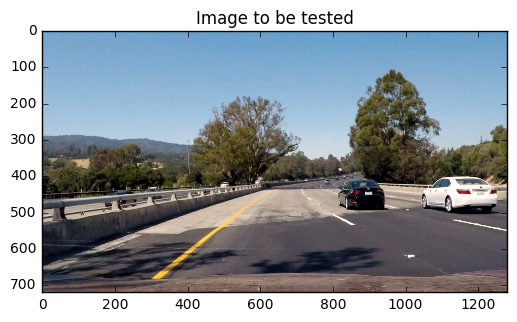

1.0


In [578]:
test_image=mpimg.imread('test_images/test4.jpg')
draw_image = np.copy(test_image)
test_image = test_image.astype(np.float32)/255
fig = plt.figure()
plt.imshow(test_image)
plt.title('Image to be tested')
plt.show()
print(np.max(test_image))

In [579]:
windows= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[350,600], 
                    xy_window=(80, 64), xy_overlap=(0.5, 0.5)))
windows+= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400,620], 
                    xy_window=(96, 96), xy_overlap=(0.7, 0.7)))
windows+= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[410,640], 
                    xy_window=(160, 128), xy_overlap=(0.8, 0.5)))

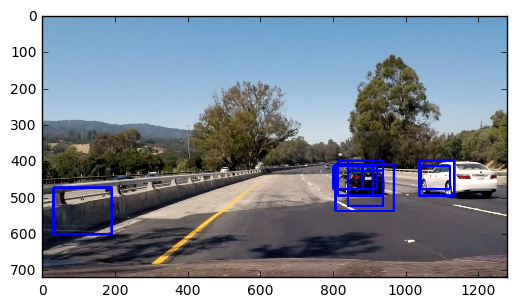

In [580]:
spatial_feat = True# Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
orient = 9
pix_per_cell = 8
cell_per_block = 2
spatial_size = (32,32)
histbin = 32
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
method='ALL'
color_space='YUV'
hist_range=(0, 256)

hot_windows = search_windows(test_image, windows, svc, X_scaler, color_space=color_space, method=method,
                        spatial_size=spatial_size, hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)          

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)  

cv2.imwrite('hotwindow_on_originalimage.png',window_img)

plt.imshow(window_img)
plt.show()

## Definitions for heat map

In [581]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

## Testing heatmap

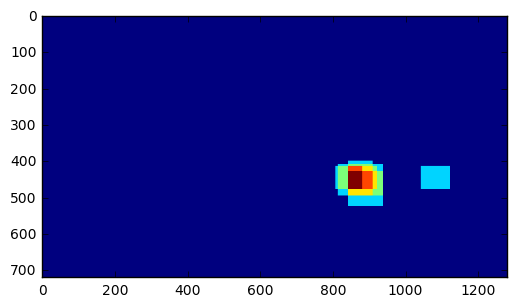

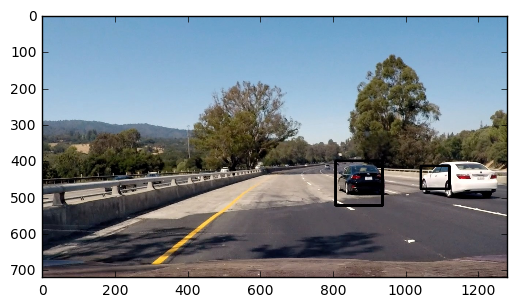

True

In [584]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
heat = add_heat(heat,hot_windows)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

cv2.imwrite('heat_map.png',heatmap)
plt.imshow(heatmap)
plt.show()
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)
plt.imshow(draw_img)
plt.show()
cv2.imwrite('final_box.png',draw_img)

## Pipelining the previous steps

In [571]:
count=0
nr_iterations=4
array_heatmap=[]

def process_vd(image):
    global count
    global array_heatmap
    global nr_iterations
    global svc,X_scaler,color_space,spatial_size,histbin,orient,pix_per_cell,cell_per_block,hog_channel
    marked_image=np.copy(image)
    if (np.max(image)>1):
        image=image.astype(np.float32)/255
        
    windows= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[400,550], 
                    xy_window=(104, 96), xy_overlap=(0.75, 0.75)))
    windows+= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[390,590], 
                    xy_window=(145, 140), xy_overlap=(0.75, 0.75)))
    windows+= (slide_window(test_image, x_start_stop=[None, None], y_start_stop=[410,660], 
                    xy_window=(135, 100), xy_overlap=(0.6, 0.6)))
    
    hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, method=method,
                        spatial_size=spatial_size, hist_bins=histbin, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)    
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heat,hot_windows)
    array_heatmap.append(heat)
    if count>nr_iterations:
        array_heatmap.pop(0)
    count=count+1
    avg_heatmap=np.mean(np.asarray(array_heatmap),axis=0)
    heat_threshold=2
    heat = apply_threshold(avg_heatmap,heat_threshold)
    labels = label(heat)
    output_image= draw_labeled_bboxes(marked_image,labels)
    return output_image

In [572]:
from moviepy.editor import VideoFileClip
clip = VideoFileClip('../CarND-Vehicle-Detection-master/project_video.mp4')
out_clip = clip.fl_image(process_vd)
out_clip.write_videofile('./project_video_output.mp4', audio=False);


[MoviePy] >>>> Building video ./project_video_output.mp4
[MoviePy] Writing video ./project_video_output.mp4


100%|█████████▉| 1260/1261 [21:35<00:01,  1.02s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./project_video_output.mp4 

